# Sistema Solar - Algoritmo de Verlet

In [1]:
#Librerias necesarias

import os
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, set_num_threads, get_num_threads, config
import time

In [2]:
#Fijamos el numero de hilos
config.THREADING_LAYER = 'omp'
set_num_threads(6)

In [3]:
#Definimos constantes
MS = 1.989*10**30     #Masa del Sol
UA = 1.52098233*10**11       #Unidad Astronómica
G = 6.67*10**(-11)      #Constante de gravitación
h = 0.0001              #Paso de tiempo
NIter = 100000          #Número de iteraciones
h_saved = 40          #Paso de guardado
NP = 14                  #Número de planetas

In [4]:
#Creamos las matrices donde se almacenaran las masas, excentricidades, posiciones y velocidades iniciales de los planetas
m_0 = np.zeros(NP)
ex = np.zeros(NP)
pos_0 = np.zeros((NP, 2))
vel_0 = np.zeros((NP, 2))

In [5]:
#Cargamos los datos de los planetas desde un archivo
datos = np.loadtxt("iniciales.txt", skiprows=1)
datos = datos[:NP]  # Aseguramos que solo tomamos los primeros NP planetas

m_0 = datos[:, 0]
ex = datos[:, 1]
pos_0[:, 0] = datos[:, 2]
pos_0[:, 1] = 0  # Inicializamos la coordenada y en 0


In [6]:
def init_velocities(ex, pos_0):
    for i in range(1, NP):
        vel_0[i, 0] = 0
        vel_0[i, 1] = np.sqrt(UA * (1 - ex[i])/ ((1 + ex[i]) * pos_0[i, 0]))
    return vel_0

In [7]:
#Definimos las funciones para reescalar las masas y posiciones
def reescalar_masas(masas):
    return masas / MS

def reescalar_posiciones(posiciones):
    return posiciones / UA


In [8]:
#Reescalamos las masas y posiciones
masas = reescalar_masas(m_0)
pos = reescalar_posiciones(pos_0)
vel = init_velocities(ex , pos_0)

## Algoritmo de Verlet

In [9]:
@jit(nopython=True, fastmath=True)
def compute_acc(pos, masas, NP):
    a = np.zeros((NP,2))
    for i in prange(NP):
        xi, yi = pos[i,0], pos[i,1]
        ax, ay = 0.0, 0.0
        for j in prange(NP):
            if i == j: continue
            dx = pos[j,0] - xi
            dy = pos[j,1] - yi
            inv_r3 = 1.0/( (dx*dx + dy*dy)**1.5 )
            ax += masas[j] * dx * inv_r3
            ay += masas[j] * dy * inv_r3
        a[i,0] = ax
        a[i,1] = ay
    return a

@jit(nopython=True, fastmath=True)
def verlet_velocity(pos, vel, masas, h, NP, Niter, h_saved):
    n_saves = Niter // h_saved
    posiciones = np.zeros((n_saves, NP, 2))
    velocidades = np.zeros((n_saves, NP, 2))

    # aceleración inicial
    a = compute_acc(pos, masas, NP)
    save_idx = 0

    for t in prange(Niter):
        # 1) actualizar posiciones
        for i in prange(NP):
            pos[i,0] += vel[i,0]*h + 0.5*a[i,0]*h*h
            pos[i,1] += vel[i,1]*h + 0.5*a[i,1]*h*h

        # 2) calcular nueva aceleración
        a_new = compute_acc(pos, masas, NP)

        # 3) actualizar velocidades
        for i in prange(NP):
            vel[i,0] += 0.5*(a[i,0] + a_new[i,0])*h
            vel[i,1] += 0.5*(a[i,1] + a_new[i,1])*h

        # 4) preparamos para el siguiente paso
        a = a_new

        # 5) guardado
        if (t+1) % h_saved == 0:
            posiciones[save_idx] = pos
            velocidades[save_idx] = vel
            save_idx += 1

    return posiciones, velocidades
    

In [10]:
# Ejecutamos el algoritmo de Verlet

t0 = time.perf_counter()
posiciones, velocidades= verlet_velocity(pos, vel, masas, h, NP, NIter, h_saved)
t = time.perf_counter() - t0
print(f"Tiempo de ejecución: {t:.2f} segundos")

Tiempo de ejecución: 6.22 segundos


In [11]:
#Guardamos los resultados en un archivo

with open("posiciones.txt", "w") as f:
    pass

for t in range(int(NIter/h_saved) - 1):
    with open("posiciones.txt", "a") as f:
        for i in range(NP):
            f.write(f"{posiciones[t,i,0]},{posiciones[t,i,1]}\n")
        f.write("\n")

In [12]:
#Guardamos los resultados en un archivo

with open("posicionesgeo.txt", "w") as f:
    pass

for t in range(int(NIter/h_saved) - 1):
    with open("posicionesgeo.txt", "a") as f:
        for i in range(NP):
            f.write(str(np.subtract(posiciones[t,i,0],posiciones[t,3,0])) + ", " + str(np.subtract(posiciones[t,i,1],posiciones[t,3,1])) + "\n")
        f.write("\n")

## Calculo de la energía

In [13]:
e_cinet = np.zeros((NP, int(NIter/h_saved-1)))
e_pot = np.zeros((NP, int(NIter/h_saved-1)))
e_total = np.zeros((int(NIter/h_saved-1)))

In [14]:
#Calculamos la energía total del sistema
@jit(nopython=True, fastmath=True)
def calcular_energia_total(pos, vel, masas, NP):
    n_steps = pos.shape[0]
    NP      = pos.shape[1]
    
    e_cinet = np.zeros((NP, n_steps))
    e_pot   = np.zeros((NP, n_steps))
    e_total = np.zeros(n_steps)
    
    for t in range(n_steps):
        # 1) Energía cinética y potencial por planeta
        for i in range(NP):
            # --- cinética ---
            vx = vel[t, i, 0]
            vy = vel[t, i, 1]
            e_cinet[i, t] = 0.5 * masas[i] * (vx*vx + vy*vy)
            
            # --- potencial (escalar) ---
            aux = 0.0
            xi, yi = pos[t, i, 0], pos[t, i, 1]
            for j in range(NP):
                if i != j:
                    xj, yj = pos[t, j, 0], pos[t, j, 1]
                    dx = xi - xj
                    dy = yi - yj
                    dist = np.sqrt(dx*dx + dy*dy)
                    aux -= masas[i] * masas[j] / dist
            e_pot[i, t] = aux
        
        # 2) Energía total del sistema en el paso t
        suma_t = 0.0
        for i in range(NP):
            suma_t += e_cinet[i, t] + e_pot[i, t]
        e_total[t] = suma_t
    
    return e_cinet, e_pot, e_total

In [15]:
t0 = time.perf_counter()
K,U,E = calcular_energia_total(posiciones, velocidades, masas, NP)
t = time.perf_counter() - t0
print(f"Tiempo de ejecución: {t:.2f} segundos")

Tiempo de ejecución: 0.32 segundos


In [16]:
# Tras llamar a tu función y obtener
# K : array (NP, n_steps) de energías cinéticas por planeta
# U : array (NP, n_steps) de energías potenciales por planeta
# E : array (n_steps,)    de energía total del sistema
# (en tu código vendrían de:)
# K, U, E = calcular_energia_total(posiciones, velocidades, masas)

# 1) Sumamos sobre planetas para obtener un vector por tipo de energía
K_sum = np.sum(K, axis=0)    # (n_steps,)
U_sum = np.sum(U, axis=0)    # (n_steps,)
E_tot = E                    # (n_steps,)

# 2) Apilamos las tres series como columnas
datos = np.column_stack((K_sum, U_sum, E_tot))  # forma (n_steps, 3)

# 3) Guardamos en un .txt con un encabezado
np.savetxt(
    "energias.txt",
    datos,
    header="Kinetic   Potential   Total",
    fmt="%.6e",
    comments=""    # quita el '#' que np.savetxt antepone al header
)
print("Energías guardadas en 'energias.txt'")


Energías guardadas en 'energias.txt'


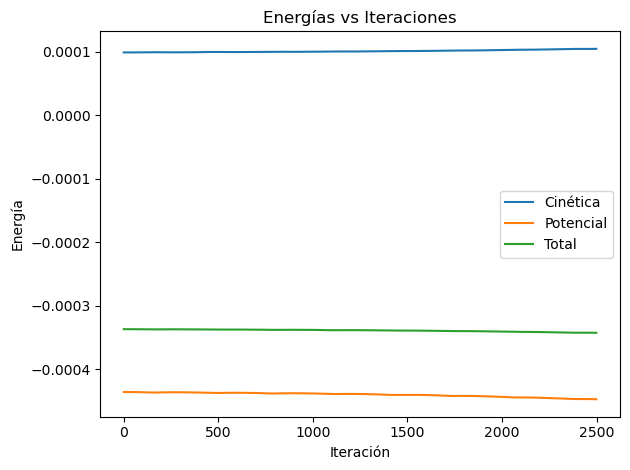

In [17]:
# 1) Cargar el fichero generado antes con np.savetxt(...)
#    Asegúrate de que 'energias.txt' existe en el directorio de trabajo
datos = np.loadtxt('energias.txt', skiprows=1)

# 2) Extraer cada serie
K_sum = datos[:, 0]   # Energía cinética total
U_sum = datos[:, 1]   # Energía potencial total
E_tot = datos[:, 2]   # Energía total

# 3) Vector de iteraciones
t = np.arange(K_sum.shape[0])

# 4) Plot
plt.figure()
plt.plot(t, K_sum, label='Cinética')
plt.plot(t, U_sum, label='Potencial')
plt.plot(t, E_tot, label='Total')
plt.xlabel('Iteración')
plt.ylabel('Energía')
plt.legend()
plt.title('Energías vs Iteraciones')
plt.tight_layout()
plt.show()
